# Predicting how much of a resource is used by strains in coculture

## Begin with modeling resource utilization for each resource for each species
Every microbial species has its own resource preferences, which can change based on physiological need. Measuring these preferences for a strain grown in a given environmental condition are relatively simple, and have been discussed elsewhere. However, what happens when you grow multiple isolates together in the same environment? Can you predict how the co-culture will consume resources?

For a given species $i$, the function describing how that species depletes a substrate $j$ is described by the 'Behrends equation,' from Behrends *et. al.*, 2009:
$$ \xi_{ij} = \frac{a_{ij}}{1+e^{\frac{t-t_{50_{ij}}}{w_{ij}}}}+o_{ij}$$
Where:
* $t$ is time
* $o$ is the offset, or lowest resource concentration
* $a$ is the amplitude, or the difference between starting concentration and lowest concentration
* $t_{50}$ is the time of half amplitude
* $w$ is the width, or the amount of time it takes for a substrate to be depleted from 75% to 25% of the total available amount

To predict how a mixed culture would deplete a given substrate, we hypothesized that you could sum the model of each species in the culture, for a given substrate, based on the following assumptions:

1. Species are 'blind' to neighbors. That is, their resource preferences and usage rates are unchanged based on what other species are present.
2. Cells do not 'pop' and release resources back into the environment

It is also important to note that, currently, the predictive power of this model is limited to the following experimental conditions:
1. The mixed culture is grown in the exact same medium and conditions as the individual cultures
2. The same number of cells of each species are used to inoculate the medium

In a mixed culture, the usage pattern of a given resource $j$ by a given species $i$ can be described as:

$$ \frac{a_{ij}'}{1+e^{\frac{t-t_{50_{ij}}'}{w_{ij}'}}}+o_{ij}'$$

Where $o'$ is a new offset parameter, based on how much of resource $j$ is consumed by species $i$ in the mixed culture. For example, if there are three species in the mixed culture, and one consumes 20 units of $j$, the second consumes 70 units, and the third 10 out of 100 units total, then $o_j'$ for the first species would be 80, for the second would be 30, and for the third would be 90. Once knowing this new offset parameter, one can flatten $\xi_{ij}$ at the time when  $o_{ij}'$ is reached, generating a rough estimate of what the resource usage will look like of the species in a mixed culture. The remaining parameters can be recalculated and fitted based on this rough estimate.

Then, the usage patterns of a given resource by multiple species in the system of species $[species]$, when mixed, can be simply combined, giving us: 
$$ \sum^{species}_{i=1} \frac{a_{ij}'}{1+e^{\frac{t-t_{50_{ij}}'}{w_{ij}'}}}+o_{ij}'$$

This notebook will describe all of these steps, including the calculation of $o'$ for each compound and each species.

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.optimize import leastsq
from matplotlib import pylab as plt
%matplotlib inline

plt.rcParams['pdf.fonttype']=42
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 2 # set the value globally

### Load the data object file from the previous notebook (Fit Time Series Metabolomics Data)

In [2]:
with open('../Data/metabolomics_data_including_fit.pkl', 'r') as f:
    data = pickle.load(f)

### The first task is to average all of the calculated and fitted parameters for each strain, replicate, and compound.

In [3]:
#make new array to hold averaged parameters : parameters = [a, o, t50, width]
#dimension 1 is dim1/3 (strains divided by number of replicates)
#dimension 2 is dim2 (compounds)
#dimension 3 of the array represents average amplitude[0], average offset[1], average t50[2], and average width[3] of that compound for the behrends equation
#dimension 4 holds the average[0] and standard deviation[1]
count = 0
#assuming that there are only three replicates
data['avg_params'] = np.ndarray(shape = (len(data['dim1'])/3, len(data['dim2']), 4, 2), dtype = float)
data['avg_dim1'] = []
while count < len(data['dim1']):
    for i in range(len(data['dim1'])/3):
        for ii in range(len(data['dim2'])):
            #First average the data
            dim1 = np.array([count, count+1, count+2])
            dim2 = np.array([ii])
            for iii in range(4):
                data['avg_params'][i][ii][iii][0] = np.average(data['parameters'][dim1, dim2[:, np.newaxis], iii]) #average 
                data['avg_params'][i][ii][iii][1] = np.std(data['parameters'][dim1, dim2[:, np.newaxis], iii]) #stdev 
        #new list of strain names
        data['avg_dim1'].append(data['dim1'][count].split(' ')[0])
        count += 3

### Now define all of the functions to be used in this notebook:

In [4]:
def behrends (a, o, w, h, t):
    '''
    From, Time-Resolved Metabolic Footprinting for Nonlinear Modeling of Bacterial Substrate Utilization
    Behrends, Ebbels, Wiliams, and Bundy
    
    Input
    a: the amplitude between the starting point and the lowest level a metabolite goes to
    o: the offset, which is the final amplitude
    w: the width or time of the exponent to go from 1 to -1
    h: the t_50 or t one-half, which is the time at half-amplitude
    t: a 1d numpy array representing time points

    Output:
    y: a 1d numpy array representing the magnitude of a given metabolite over time
    
    Model:
    y = a / (1 + np.exp( (t - h) / w)) + o
    '''
    return a / (1 + np.exp( (t - h) / w ) ) + o

def crossfinder (y, c):
    '''
    Finds the point at which a plot crosses a certain y-value
    
    Input
    y: list of y-values
    c: y-value that the plot crosses
    
    Output
    cidx = index of y where it crosses c
    '''
    cidx = 0
    for idx, point in enumerate(y[:-1]):
        if (point < c and y[idx+1] > c):
            #if this data point is less than the starting concentration and the next data point is greater than it
            #store this data point as the one that hits the starting concentration
            y_cross = point
            cidx = idx
#     print y_cross
#     print cidx
    
    return cidx

###These functions for new curve fitting
def my_func(t,a,o,p):
    '''
    From, Time-Resolved Metabolic Footprinting for Nonlinear Modeling of Bacterial Substrate Utilization
    Behrends, Ebbels, Wiliams, and Bundy
    
    Input
    t: a 1d numpy array representing time points that were sampled
    a: the amplitude between the starting point and the lowest level a metabolite goes to
    o: the offset, which is the final amplitude
    p: the parameters in the model below
    
    Output:
    y: a 1d numpy array representing the magnitude of a given metabolite over time
    
    Model:
    y = a / (1 + np.exp( (t - p[0]) / p[1])) + o
    
    where:
    p[0] is the t_50 or t one-half, which is the time at half-amplitude
    p[1] is the width or time of the exponent to go from 1 to -1

    Authors:
    Ben Bowen and Onur Erbilgin
    2015, December 3
    JGI, Berkeley Lab
    
    '''
    return a / (1 + np.exp( (t - p[0]) / p[1] ) ) + o

def my_residual(p,t,y,a,o):
    for i in p:
        if i < 0:
            return y + 1e20
    return y-my_func(t,a,o,p)

def dimensions (items, cols):
    '''
    Returns the appropriate dimensions for a plot, given the number of columns desired and items to be plotted
    
    Input
    items: number of items you want to plot
    cols: number of columns you would like
    
    Output
    rows: appropriate number of rows for the plot
    '''
    if items % cols == 0:
        rows = items / cols
    else:
        rows = (items / cols) + 1
    
    return rows

def get_col(val):
    #returns 'red' if the value meets an argument
    if val >= 0.99:
        return 'green'
    elif val < 0.9:
        return 'red'
    else:
        return 'black'

#behrends differentials for error calculations
def dbdt(a,o,w,h,t):
    return a*np.exp((-h + t)/w)/(w*(np.exp((-h + t)/w) + 1)**2)
def dbda(a,o,w,h,t):
    return 1 / (np.exp((t - h) / w) + 1)
def dbdh(a,o,w,h,t):
    return a * np.exp((t - h) / w) / (w * (np.exp((t - h) / w) + 1)**2)
def dbdw(a,o,w,h,t):
    return ( a * (t - h) * np.exp((t - h) / w)) / (w**2 * (np.exp((t - h) / w) + 1)**2)

### Now define the time dimension and starting concentration of each metabolite for the model calculation

In [5]:
#set timepoints
time = np.linspace(0.0,24.0, num = 10000)

#set starting concentration of metabolites for all strains
#by averaging the observed starting concentration for each strain
#since amplitude and offset were calculated based on data, use standard deviation to represent spread of data
start = {}
for ii, compound in enumerate(data['dim2']):
    sumax = 0
    temp = []
    for i, strain in enumerate(data['dim1']):
        #add amplitude plus offset to get start
        temp.append(data['parameters'][i][ii][0] + data['parameters'][i][ii][1])
    avg_max = np.mean(temp)
    stdv_max = np.std(temp)
    #index [0] is average, [1] is standard deviation
    start[compound.replace(' Results Final Conc.', '')] = [avg_max, stdv_max]

### Import the experimental observations of co-culture resource usage

In [6]:
#coculture metabolite depletion observations

obs = pd.read_csv('../Data/20160328_Enigma_coculture_avg_v2.csv')
obs

,Time,tryptophan,phenylalanine,leucine,isoleucine,methionine,proline,valine,glucose,tyrosine,...,threonine,histidine,glycine,glutamine,asparagine,serine,glutamate,aspartate,lysine,arginine
0,0,104516.81130,103302.79500,108667.385400,103521.57560,115198.56560,103646.96930,103939.07170,92138.935470,9947.590400,...,102845.864900,88479.545970,101223.018600,102250.56930,95947.75280,97161.92083,96811.141530,88171.67383,95559.277300,98341.991030
1,1,94517.92447,94382.99783,96626.176600,93798.48703,99009.07233,94187.15000,94479.84770,85087.458630,8946.332800,...,94283.918130,83448.346400,90056.561130,87314.34590,80405.35057,84897.71680,79250.585270,78149.79157,84785.973930,86862.687400
2,2,99075.01380,98612.44170,103087.970700,99033.03920,113021.58320,97927.08520,100914.24530,79428.443850,9397.002300,...,101910.584600,114886.459400,112136.498300,88700.54205,85412.48040,95183.52715,75721.598350,92618.86440,96711.798300,95124.293800
3,3,93401.75410,92621.34800,92725.763670,93275.32310,104116.07540,90907.37943,96967.67207,43241.841400,9036.789400,...,100834.445600,84928.190070,150144.417000,56713.49757,55488.46420,89399.53633,56061.926870,79634.39897,100085.198400,87511.318270
4,4,78019.47350,77419.34110,70922.415770,73828.55753,88838.67920,64607.34897,82917.73137,590.101733,8046.676867,...,81836.341230,69555.837630,NaN,0.00000,0.00000,37157.16147,21246.371770,17418.98337,79459.278570,41269.452400
5,5,42392.03563,42833.78390,42478.593530,40946.54960,70848.51717,0.00000,59620.74367,572.464267,7482.885833,...,43841.105330,39949.893870,105745.712700,0.00000,0.00000,470.88580,638.210600,0.00000,59741.596300,71.866067
6,6,0.00000,0.00000,6644.377467,4237.08320,43175.52123,0.00000,16217.95670,552.243767,95.202767,...,6859.527100,73.365700,40897.702070,0.00000,0.00000,0.00000,218.666433,0.00000,388.601633,0.000000
7,7,0.00000,0.00000,0.000000,0.00000,41515.13933,0.00000,0.00000,546.472833,7.036667,...,213.292533,27.122900,660.719967,0.00000,0.00000,0.00000,44.236200,0.00000,387.743333,0.000000
8,8,0.00000,0.00000,0.000000,0.00000,38367.72410,0.00000,0.00000,529.695467,0.000000,...,202.235867,20.313800,0.000000,0.00000,0.00000,0.00000,45.390600,0.00000,383.575733,0.000000
9,9,0.00000,0.00000,0.000000,0.00000,41361.24313,0.00000,0.00000,526.372433,0.000000,...,204.178633,33.192933,0.000000,0.00000,0.00000,0.00000,48.212700,0.00000,389.367767,0.000000


In [7]:
#coculture metabolite depletion standard error

obs_stderr = pd.read_csv('../Data/20160328_Enigma_coculture_stderr_v2.csv')
obs_stderr

,Time,tryptophan,phenylalanine,leucine,isoleucine,methionine,proline,valine,glucose,tyrosine,...,threonine,histidine,glycine,glutamine,asparagine,serine,glutamate,aspartate,lysine,arginine
0,0,230.990582,265.868808,1384.309259,778.634042,3267.031758,285.270430,234.716311,499.545273,74.429354,...,627.031512,2303.365229,1543.208558,2781.711343,5764.966332,3846.002065,4554.599173,7174.932469,3956.571658,2076.244573
1,1,1149.217206,1197.842011,1235.805465,1445.185660,2929.253799,701.123115,924.101617,2496.085935,140.794745,...,2853.103180,8643.819009,5090.174861,4056.747386,8396.127238,7164.222991,6915.603855,12409.825100,9166.762802,6760.597665
2,2,1310.282000,811.074800,1247.462650,1349.627700,2533.611400,538.016700,301.537450,2723.723650,31.839200,...,1481.167000,22283.415470,8946.337500,5358.071950,12336.466000,10650.675650,6938.839550,15404.935500,10709.356300,7047.482200
3,3,445.153488,454.674709,1693.272146,1679.251022,3140.919294,2088.239074,1198.741218,729.868876,105.448846,...,2589.670645,11068.656160,8767.947504,2611.180417,1425.058950,1764.196956,1946.024461,1313.893455,3088.350548,2158.632184
4,4,725.125622,370.007844,1992.985659,911.227246,3201.183322,1809.086906,1239.732324,31.344214,181.633091,...,768.383782,3766.434717,NaN,0.000000,0.000000,2217.550570,700.765779,2048.074432,5907.685500,10356.323630
5,5,540.058589,315.125793,503.828346,355.153582,920.474950,0.000000,255.237677,21.074430,129.614849,...,817.782856,764.971610,3096.175637,0.000000,0.000000,57.826364,10.644977,0.000000,2284.871728,71.866067
6,6,0.000000,0.000000,290.995016,304.292163,3286.916241,0.000000,387.947874,10.429769,4.356377,...,462.535023,18.992136,826.441293,0.000000,0.000000,0.000000,15.045028,0.000000,10.413661,0.000000
7,7,0.000000,0.000000,0.000000,0.000000,6018.122423,0.000000,0.000000,13.065806,3.557858,...,2.104069,2.402892,420.136553,0.000000,0.000000,0.000000,6.101882,0.000000,11.396313,0.000000
8,8,0.000000,0.000000,0.000000,0.000000,3022.563543,0.000000,0.000000,4.869181,0.000000,...,1.161801,5.366691,0.000000,0.000000,0.000000,0.000000,4.464910,0.000000,13.998698,0.000000
9,9,0.000000,0.000000,0.000000,0.000000,3575.873745,0.000000,0.000000,1.301269,0.000000,...,2.407176,7.185847,0.000000,0.000000,0.000000,0.000000,4.403632,0.000000,15.480979,0.000000


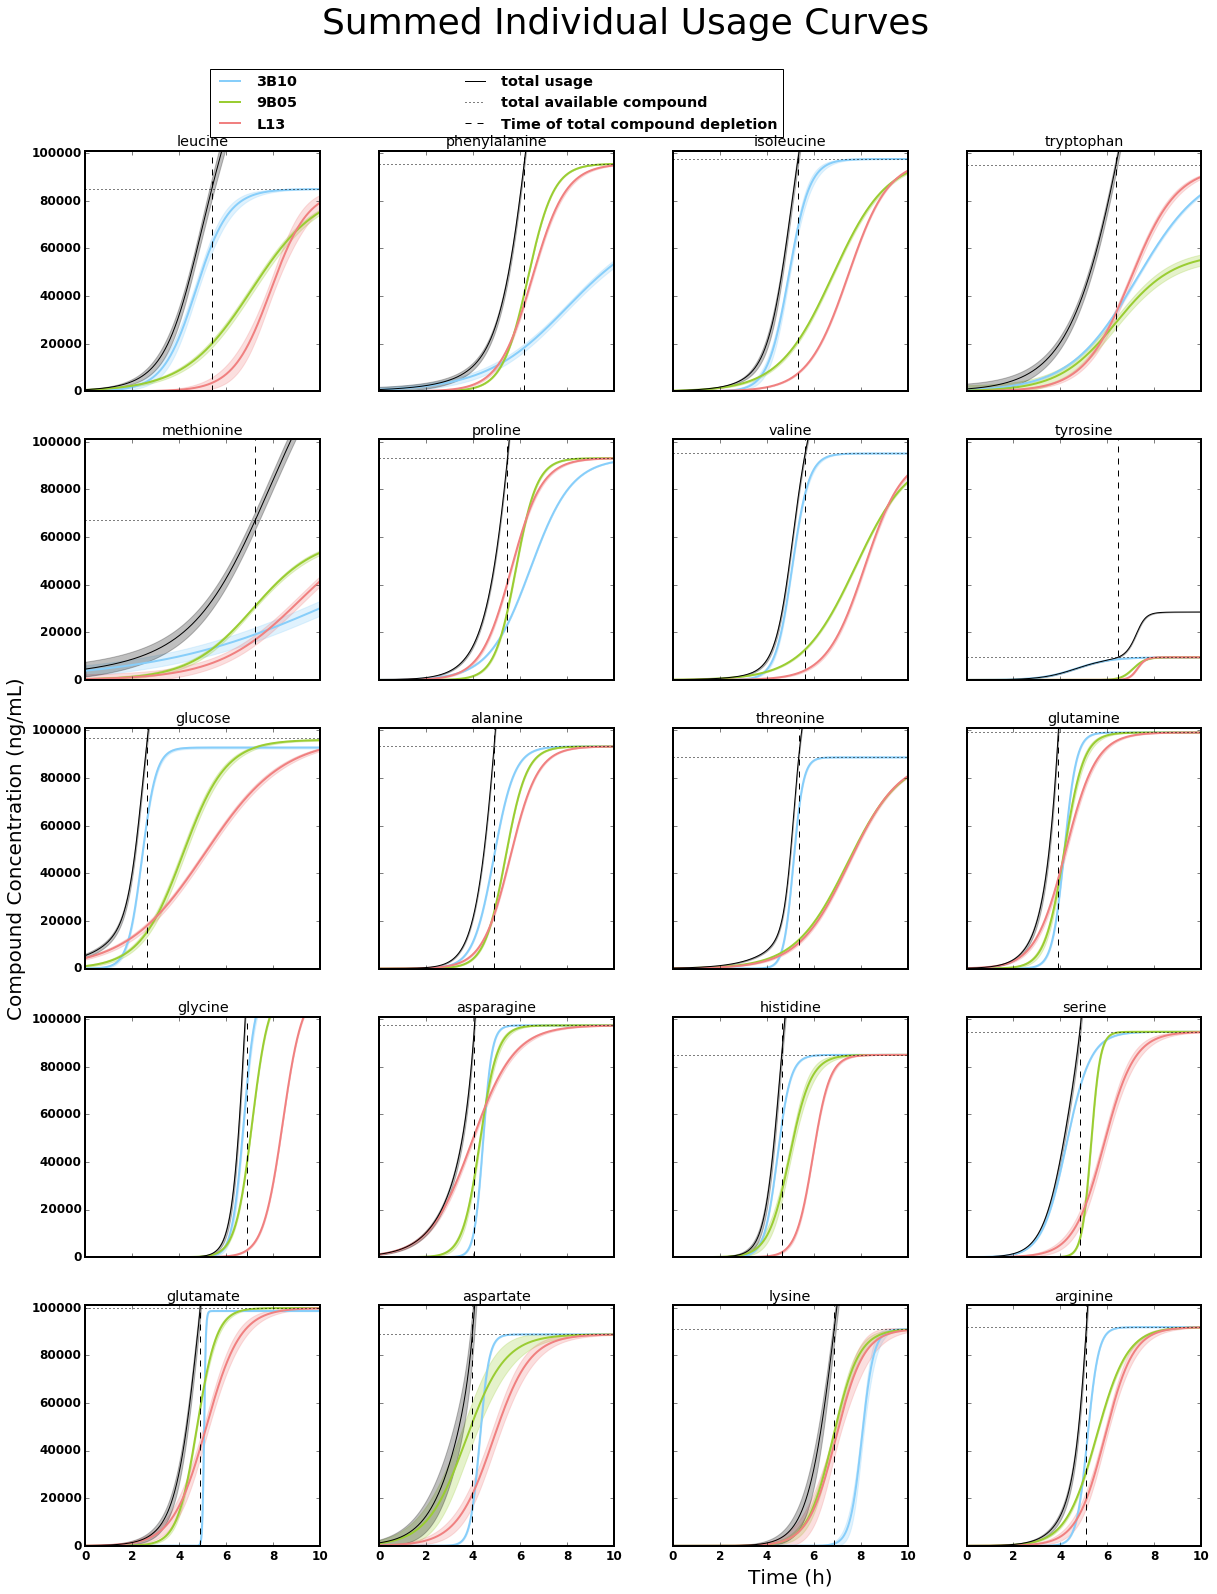

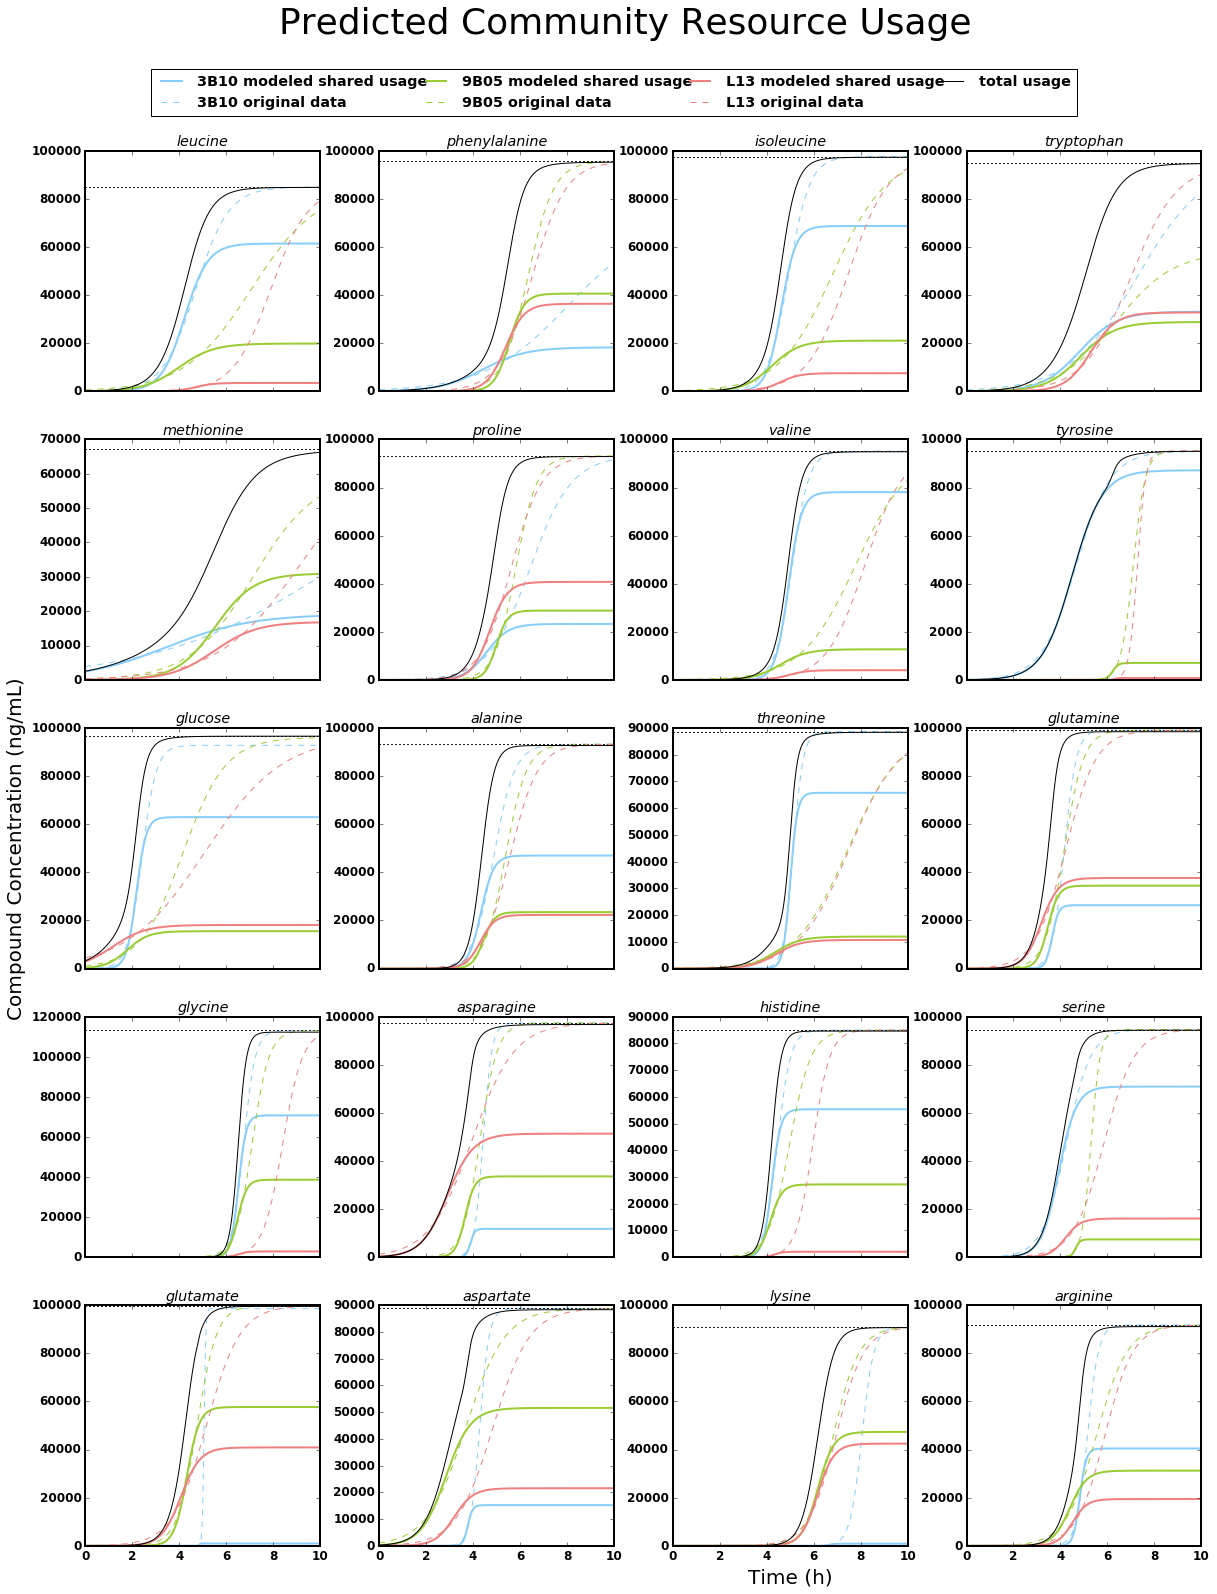

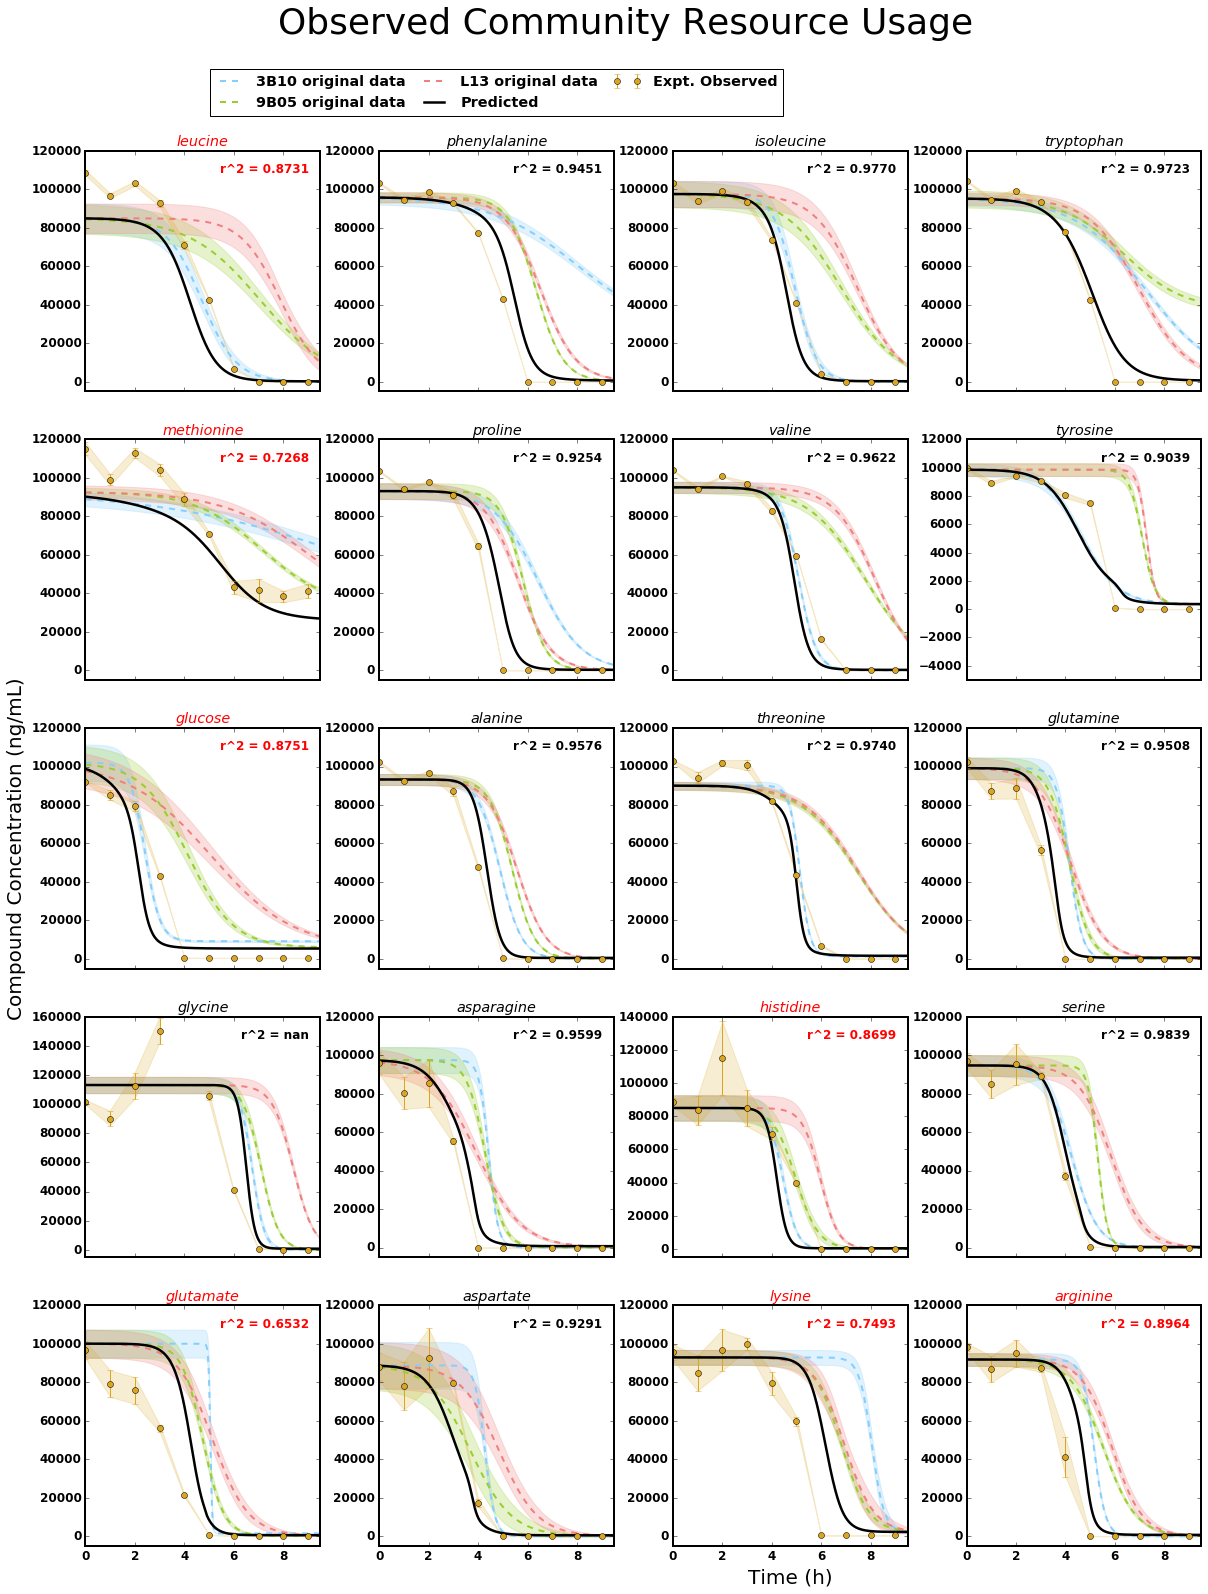

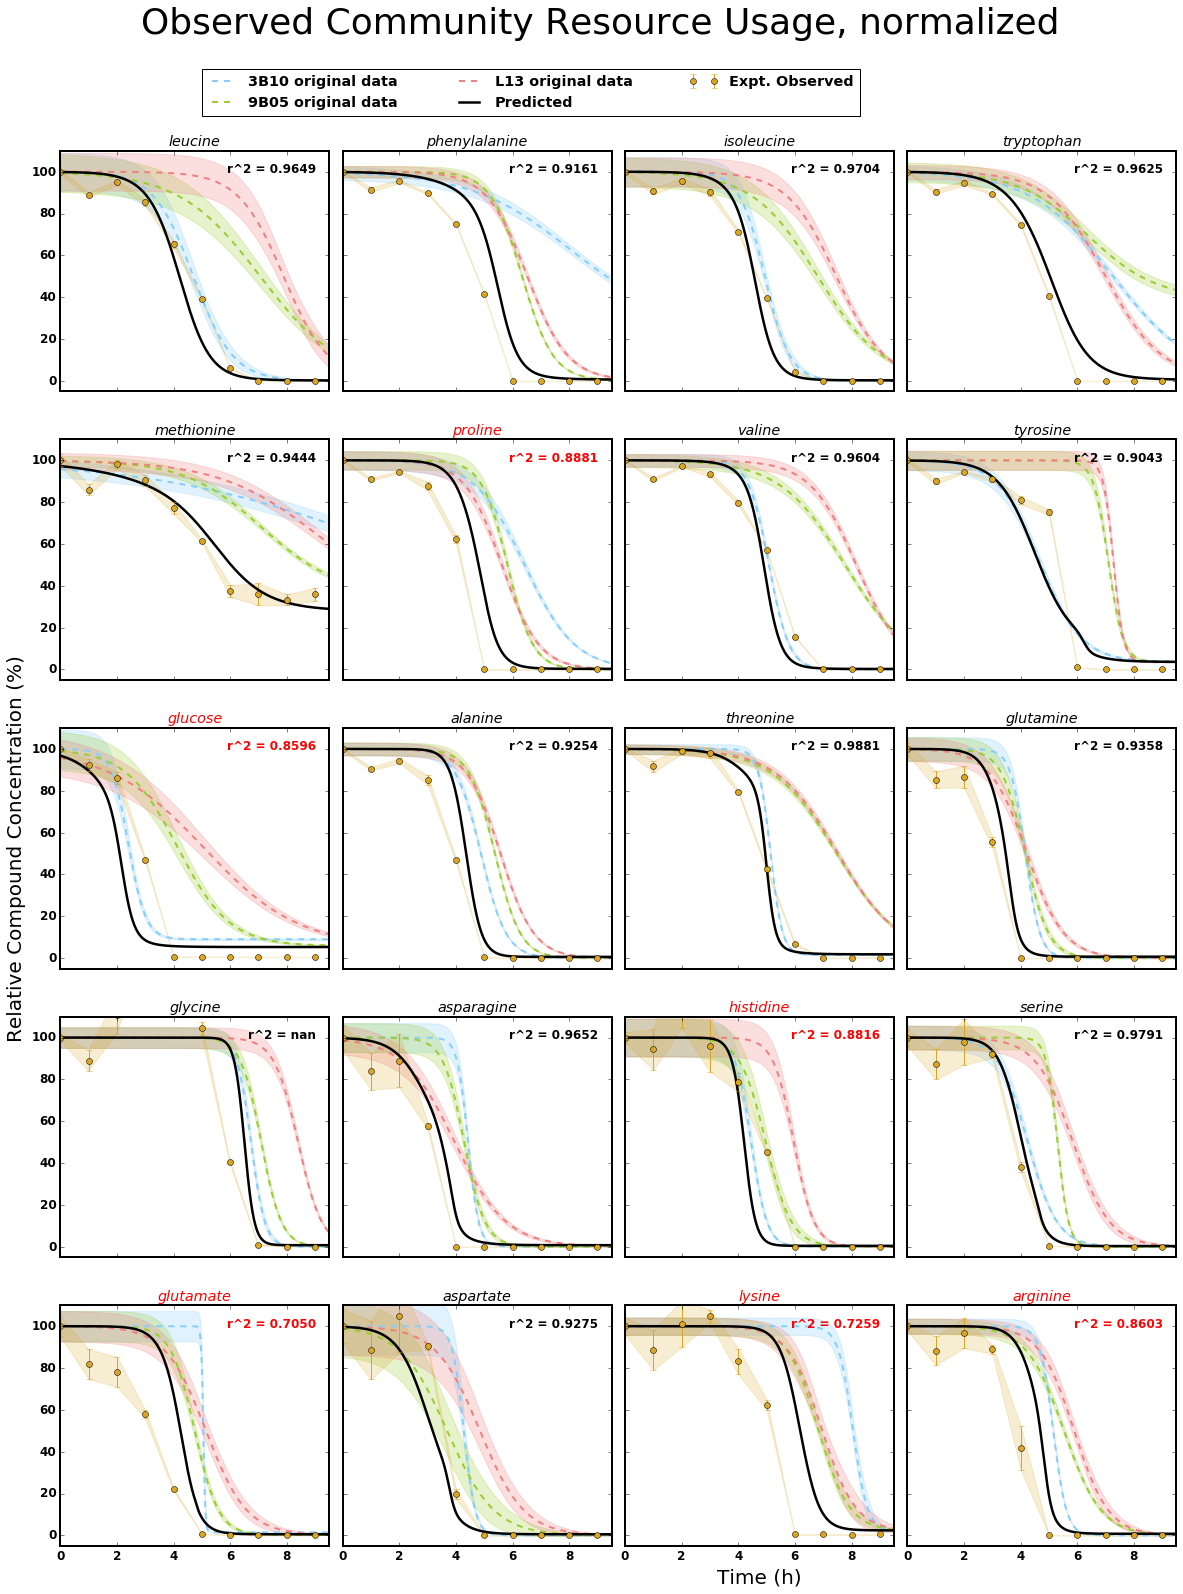

In [8]:
#new plotting, shared axes

#book keeping variables
num_strains = len(data['avg_dim1'])
num_compounds = len(data['dim2'])
#plotting info
cols = 4
rows = dimensions(num_compounds, cols)

#array to hold estimate of how much of the compound was used by each strain in mixed conditions
#dimensions strains x compounds
data['compound_usage'] = np.zeros((len(data['avg_dim1']), len(data['dim2'])))

#colors to represent each species
colors = [
    'lightskyblue',
    'yellowgreen',
    'lightcoral'
]

#set up the plots
 #individual usage plots, individual cultures
fig1, axs1 = plt.subplots(rows, cols, sharex = True, sharey = True)
axs1 = axs1.ravel()

#calculated blind co-culture usage plots
fig2, axs2 = plt.subplots(rows, cols, sharex = True) 
axs2 = axs2.ravel()

#observations compared to prediction, not normalized
fig3, axs3 = plt.subplots(rows, cols, sharex = True) 
axs3 = axs3.ravel()

#observations compared to prediction, normalized
fig4, axs4 = plt.subplots(rows, cols, sharex = True, sharey = True) 
axs4 = axs4.ravel()

#find which subplot to put y-label on, for centering
if rows%2 == 1:
    idx = rows/2+1
else:
    idx = rows/2
idx = idx * cols - cols
axs1[idx].set_ylabel('Compound Concentration (ng/mL)', fontsize = 20)
axs2[idx].set_ylabel('Compound Concentration (ng/mL)', fontsize = 20)
axs3[idx].set_ylabel('Compound Concentration (ng/mL)', fontsize = 20)
axs4[idx].set_ylabel('Relative Compound Concentration (%)', fontsize = 20)

#find where to put x-label
if cols%2 == 1:
    idx = cols/2+1
else:
    idx = cols/2
idx = rows*cols - idx
axs1[idx].set_xlabel('Time (h)', fontsize = 20)
axs2[idx].set_xlabel('Time (h)', fontsize = 20)
axs3[idx].set_xlabel('Time (h)', fontsize = 20)
axs4[idx].set_xlabel('Time (h)', fontsize = 20)

#calculate the predictions, for each compound at a time
for ii, cmpd in enumerate(data['dim2']):
    #need to do this again because dictionaries aren't sorted
    compound = cmpd.replace(' Results Final Conc.', '')
    
    #Set up lists of parameters for each strain
    #start new parameter list for each compound
    a = []
    o = []
    w = []
    h = []
    
    #same for stdev/error
    #stdev for a and o, since they were calculated from the data distribution
    a_std = []
    o_std = []
    #error for w and h, since they were modeled
    w_err = []
    h_err = []

    #load the lists
    for i, strain in enumerate(data['avg_dim1']):
        a.append(start[compound][0] - data['avg_params'][i][ii][1][0])#want to set max comp concentration the same across all species
        a_std.append(np.sqrt(start[compound][1]**2 + data['avg_params'][i][ii][1][1]**2))
        o.append(data['avg_params'][i][ii][1][0]) #offset stays the same because presumably the species can never eat below this amount
        o_std.append(data['avg_params'][i][ii][1][1])
        h.append(data['avg_params'][i][ii][2][0])
        h_err.append(data['avg_params'][i][ii][2][1] / 3)
        w.append(data['avg_params'][i][ii][3][0])
        w_err.append(data['avg_params'][i][ii][3][1] / 3)   

    #Figure 1 - Calculate total usage of metabolite in 'blind' mixed conditions, and estimate when the coculture will consume all the available compound
    #this is the simple summation
    #summed usage
    total_usage = 0
    total_usage_error = 0

    for i, strain in enumerate(data['avg_dim1']):
        #calculate usage plot of a species
        #usage is how much of a compound has been depleted from the medium, so subtract starting compound concentration from Behrends formula
        #This makes the plot go from zero to starting concentration minus offset, whereas the behrends goes from starting concentration to offset
        usage = start[compound][0] - behrends(a[i], o[i], w[i], h[i], time)

        #plot the usage curve
        axs1[ii].plot(time, usage, label = strain, color = colors[i], linewidth = 2)

        #sum the usage of each species to get total usage plot of the set of species   
        total_usage += usage
        
        #calculate error for the usage curve
        #this is the same error as if for behrends
        behr_err = np.sqrt(
            np.sqrt(
                #do not include error from amplitude, since this error is a result of deviation in starting concentrations, which in this model are defined and so do not have error
#             (dbda(a[i], o[i], w[i], h[i], time) * a_std[i])**2 + 
            (dbdh(a[i], o[i], w[i], h[i], time) * h_err[i])**2 +
            (dbdw(a[i], o[i], w[i], h[i], time) * w_err[i])**2)**2 +
            o_std[i]**2)
        usage_err = np.sqrt(behr_err**2)
        axs1[ii].fill_between(time, usage - usage_err, usage + usage_err, color = colors[i], alpha = 0.25)

        #also sum the error for each usage curve, to depict the error for the total usage curve
        total_usage_error += usage_err**2.

    #plot the total usage of the set of species
    axs1[ii].plot(time, total_usage, label = 'total usage', color = 'black')
    
    #and the error for total usage
    toterr = np.sqrt(total_usage_error)
    axs1[ii].fill_between(time, total_usage - toterr, total_usage + toterr, color = 'black', alpha = 0.25)

    #find when the total usage reaches the offset level of the strain that has the lowest offset
    #this strain consumes the most of it, and consumes it down to the lowest level
    master_offset = np.min(o)

    #line to depict the total amount of compound available to the strains (starting concentration minus the offset)
    axs1[ii].axhline(start[compound][0] - master_offset, linestyle = ':', color = 'black', label = 'total available compound')

    #calculate the time (index) when the total usage curve crosses the total amount of compound available to the strains
    crosses = crossfinder(total_usage, start[compound][0] - master_offset)
    
    #plot it
    axs1[ii].axvline(time[crosses], linestyle = '--', color = 'black', label = 'Time of total compound depletion')
    
    #subplot final touches
    axs1[ii].set_xlim(0, 10)
    axs1[ii].set_ylim(0,(start[compound][0] * 1.1))    
    axs1[ii].set_title(compound)

    #Figure 2- Remodel metabolite consumption of individual species, and use that to form the predicted co-culture use for each compound
    #for each strain, make the "y-measured" the original behrends curve,
    #artificially flattening out at the time when all available metabolite is used up
    newer_total_usage = 0
    newparams = []
    for i, strain in enumerate(data['avg_dim1']):
        #get behrends curve up to time when all available compound has been depleted by the coculture (predicted)
        #this value can also be used to estimate how much of a compound was used by a given species (starting concentration minus y_measured1)
        y_measured1 = behrends(a[i], o[i], w[i], h[i], time[:crosses])
        
        #now flatten the curve at this time
        #calculate how many timepoints are left in time series after crossing point
        timeleft = len(time) - crosses

        #make the rest of the curve be the last predicted measurement
        y_measured2 = np.asarray([y_measured1[-1]]*timeleft)
        
        #set up parameters for new curve fitter
        #concatenate the two sets of y_measured
        y_measured = np.append(y_measured1, y_measured2)
        #the new offset is the concentration when the curve flattened out
        o_new = y_measured1[-1]
        #the new amplitude is calculated using the starting concentration and the new offset
        a_new = start[compound][0] - o_new
        #the t50 and width are re-fit
        p_guess = [5, 1]
        out = leastsq(my_residual,p_guess,args=(time,y_measured,a_new,o_new))
        y_fit = my_func(time,a_new,o_new,out[0])
        
        #add in the list of parameters for each strain for this compound, for use later
        newparams.append([a_new, o_new, out[0]])
        
        #for plotting purposes, convert the newly modeled curves to usage curves again, and plot them
        modeled_updated_use = start[compound][0] - y_fit
        newer_total_usage += modeled_updated_use
        axs2[ii].plot(time, modeled_updated_use, color = colors[i], linewidth = 2, label = '%s modeled shared usage' %(strain))
        axs2[ii].set_title(compound, style = 'oblique')
        axs2[ii].axhline(start[compound][0] - master_offset, linestyle = ':', color = 'black')
        
        #overlay original behrends for comparison
        usage = start[compound][0] - behrends(a[i], o[i], w[i], h[i], time)
        axs2[ii].plot(time, usage, '--', color = colors[i], label = '%s original data' %(strain))
   
    #also plot the summed usage curve - this is the usage representation of the actual prediction we test
    axs2[ii].plot(time, newer_total_usage, color = 'black', label = 'total usage')    
    axs2[ii].set_xlim(0, 12)

    #figures 3 and 4 - compare the model to our observations
    for k, ob in enumerate(obs.columns):
        if ob == cmpd.replace(' Results Final Conc.', ''):
            

            
            #plot the original behrends modeling for individual usage
            for i, strain in enumerate(data['avg_dim1']):
                #calculate error
                behr_err = np.sqrt(
                    np.sqrt(
                    (dbda(a[i], o[i], w[i], h[i], time) * a_std[i])**2 + 
                    (dbdh(a[i], o[i], w[i], h[i], time) * h_err[i])**2 +
                    (dbdw(a[i], o[i], w[i], h[i], time) * w_err[i])**2)**2 +
                    o_std[i]**2)
                #absolute
                axs3[ii].plot(time, behrends(a[i], o[i], w[i], h[i], time), 
                              color = colors[i], linestyle = '--', linewidth = 2, 
                              label = '%s original data' %(strain))
                axs3[ii].fill_between(time,
                                      (behrends(a[i], o[i], w[i], h[i], time) - behr_err),
                                      (behrends(a[i], o[i], w[i], h[i], time) + behr_err),
                                      color = colors[i], alpha = 0.25)
                
                #normalized
                axs4[ii].plot(time, behrends(a[i], o[i], w[i], h[i], time)/start[compound][0]*100, 
                              color = colors[i], linestyle = '--', linewidth = 2, 
                              label = '%s original data' %(strain))
                axs4[ii].fill_between(time,
                                      (behrends(a[i], o[i], w[i], h[i], time) - behr_err) / start[compound][0]*100,
                                      (behrends(a[i], o[i], w[i], h[i], time) + behr_err) / start[compound][0]*100,
                                      color = colors[i], alpha = 0.25)
            
            #plot the prediction
            prediction = 0
            for i, strain in enumerate(data['avg_dim1']):
                prediction += start[compound][0] - my_func(time, newparams[i][0], newparams[i][1], newparams[i][2])
            prediction = start[compound][0] - prediction
            axs3[ii].plot(time, prediction, 
                          color = 'black', label = 'Predicted', linewidth = 2.5)
            #normalized
            axs4[ii].plot(time, prediction/start[compound][0]*100, 
                          color = 'black', label = 'Predicted', linewidth = 2.5)

            #load observations
            x = []
            #absolute
            y = []
            y_err = []

            for q, ti in enumerate(obs['Time']):
                x.append(ti)
                y.append(obs.iloc[q,k])
                y_err.append(obs_stderr.iloc[q,k])

            #normalize them to starting concentration
            y_norm = y / obs.iloc[0,k]*100
            y_err_norm = y_err / obs.iloc[0,k]*100

            #calculate r squared between observations and fit
            ssr = 0
            sst = 0
            for z,ys in enumerate(y):
                if np.isnan(ys):
                    pass
                else:
                    #calculate model at the timepoint
                    model = 0
                    for i, strain in enumerate(data['avg_dim1']):
                        model += start[compound][0] - my_func(x[z], newparams[i][0], newparams[i][1], newparams[i][2])
                    
                    #revert model back to a depletion curve, to accurately compare with the mass spectrometry measurements
                    fi = start[compound][0] - model
                    
                    #residual sum of squares
                    ssr += (ys - fi)**2
                    #total sum of squares
                    sst += (ys - sum(y)/float(len(y)))**2
            r2 = 1 - ssr/sst 

            #calculate r squared for normalized observations
            ssr = 0
            sst = 0
            for z,ys in enumerate(y_norm):
                if np.isnan(ys):
                    pass
                else:
                    model = 0
                    for i, strain in enumerate(data['avg_dim1']):
                        model += start[compound][0] - my_func(x[z], newparams[i][0], newparams[i][1], newparams[i][2])
                    
                    #revert model back to what the mass spec 'sees'
                    fi = start[compound][0] - model
                    fi_norm = fi / start[compound][0] * 100
                    
                    ssr += (ys - fi_norm)**2
                    sst += (ys - sum(y_norm)/float(len(y_norm)))**2
            r2_norm = 1 - ssr/sst 

            #plot the observations
            axs3[ii].errorbar(x,y,yerr = y_err,label = 'Expt. Observed', fmt = 'o', color = 'goldenrod', ecolor = 'goldenrod')
            y = np.asarray(y)
            y_err = np.asarray(y_err)
            axs3[ii].fill_between(x, y-y_err, y+y_err, color = 'goldenrod', alpha = 0.2)
            axs3[ii].set_title(compound, color = get_col(r2), style = 'oblique')
            axs3[ii].text(0.95,0.95,'r^2 = %.4f' %(r2), fontsize = 12, color = get_col(r2),
                         horizontalalignment = 'right', verticalalignment = 'top', transform = axs3[ii].transAxes)
            axs3[ii].set_xlim(0,9.5)
            axs3[ii].set_ylim(-5000,)

            #normalized
            axs4[ii].errorbar(x,y_norm,yerr = y_err_norm,label = 'Expt. Observed', fmt = 'o', color = 'goldenrod', ecolor = 'goldenrod')
            axs4[ii].fill_between(x, y_norm-y_err_norm, y_norm+y_err_norm, color = 'goldenrod', alpha = 0.2)
            axs4[ii].set_title(compound, style = 'oblique', color = get_col(r2_norm))
            axs4[ii].text(0.95,0.95,'r^2 = %.4f' %(r2_norm), fontsize = 12, color = get_col(r2_norm),
                         horizontalalignment = 'right', verticalalignment = 'top', transform = axs4[ii].transAxes)
            axs4[ii].set_xlim(0,9.5)
            axs4[ii].set_ylim(-5,110)

            

axs2[0].set_ylim(0,100000)
axs2[0].set_xlim(0,10)
    

fig1.subplots_adjust(wspace = 0.25)
fig2.subplots_adjust(wspace = 0.25)
fig3.subplots_adjust(wspace = 0.25)
fig4.subplots_adjust(wspace = 0.05)
    
axs1[0].legend(bbox_to_anchor = (0.5, 1.02, 2.5, .35), ncol = 2, mode = 'expand')
axs2[0].legend(bbox_to_anchor = (0.25, 1.02, 4, .35), ncol = 4, mode = 'expand')
axs3[0].legend(bbox_to_anchor = (0.5, 1.02, 2.5, .35), ncol = 3, mode = 'expand')
axs4[0].legend(bbox_to_anchor = (0.5, 1.02, 2.5, .35), ncol = 3, mode = 'expand')
fig1.suptitle('Summed Individual Usage Curves', fontsize = 36)
fig2.suptitle('Predicted Community Resource Usage', fontsize = 36)
fig3.suptitle('Observed Community Resource Usage', fontsize = 36)
fig4.suptitle('Observed Community Resource Usage, normalized', fontsize = 36)
#square inches per figure
inch = 5
fig1.set_size_inches(inch*cols, inch*rows)
fig2.set_size_inches(inch*cols, inch*rows)
fig3.set_size_inches(inch*cols, inch*rows)
fig4.set_size_inches(inch*cols, inch*rows)
plt.show()